# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [116]:
#оставим это поле для подлкючения библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [117]:
#посмотри на данные
real_estate = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
#real_estate.info()
real_estate.head()
real_estate.tail()
#для оценки ситуации, применим рекомендованый метод "describe" (с транспонированием)
#real_estate.describe().T

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
23694,9,9700000.0,133.81,2017-03-21T00:00:00,3,3.7,5.0,73.3,3,NaN,...,13.83,NaN,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,NaN,5.0,38.0,4,NaN,...,8.50,NaN,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,NaN,3.0,29.7,1,NaN,...,NaN,NaN,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23697,13,11475000.0,76.75,2017-03-28T00:00:00,2,3.0,17.0,NaN,12,NaN,...,23.30,2.0,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0
23698,4,1350000.0,32.30,2017-07-21T00:00:00,1,2.5,5.0,12.3,1,NaN,...,9.00,NaN,поселок Новый Учхоз,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Вывод

1. "дата публикации" - строка такого вида 2019-03-07T00:00:00 (нужно преобразовать).
2. очень много NaN (пропусков), и они разбросаны по столбцам в которых нельзя просто убрать совсем или усреднить/замедианить, видимо теперь это важно (нужно использовать) в отличие от первого проекта.
3. дни размещения думаю можно перевести в месяцы т.к. есть значения более 1000.
4. площадь квартиры с максимальным значением в 900м (реально ли это?).
5. значение аэропортов и ситицентра можно переверсти в км.
6. высота потолка - 100 м, при среднем 3 м., но есть видимо "жилище Хоббита" - 1 м всего лишь.
7. сервис Яндекс.Недвижимость не позволяет загрузить больше 30 фото, у нас максимальное значение 50, при среднем около 10, ошибка либо раньше было лучше.
8. жилая площадь 400м, хотя есть значение общей площади в 900м.

### Шаг 2. Предобработка данных

In [118]:
#Посчитаем суммарное количество пропусков
real_estate.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [119]:
#Учитывая, что в описании есть небольшая подсказка, что делать с балконами, воспользуемся ей
#Кроме того, при просмотре текущих объявлений пользователи редко указывают количество балконов, 
#видимо считают, что "по фото и так всё видно", причём акцент сделан в задаче именно на балконах, 
#хотя ведь есть ещё лоджия поэтому и меняем смело пропуски на 0
real_estate['balcony'] = real_estate['balcony'].fillna(0)

In [120]:
#Количество дней размещения
real_estate['days_exposition'].describe()
#Максимальное значение в 1580 дн. эт почти 5 лет... 
#Думаю, что либо модератор либо сам пользователь вовремя не закрыли объявление, среднее значение 180 уже лучше, 
#но думаю здесь актуальней будет медианное и оно должно быть около 90 дней
real_estate['days_exposition'] = real_estate['days_exposition'].fillna(real_estate['days_exposition'].median())
real_estate['days_exposition'].isnull().sum()

0

In [121]:
#У нас есть ещё апартаменты, это вроде бы и не жильё, но жить можно (собственно от сюда и цена на них)
real_estate['is_apartment'] = real_estate['is_apartment'].fillna(0)
#Здесь я ошибся, т.к. забыл, что у нас булевы значения, придется сделать замену на целые
real_estate['is_apartment'] = real_estate['is_apartment'].map({True: 1, False: 0})
real_estate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            23699 non-null int64
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 23699 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

In [122]:
#Количество фотографий, надо посмотреть сколько их, т.к. повторюсь сервис допускает не более 30
#real_estate['total_images'].describe()
#real_estate['total_images'].unique()
real_estate['total_images'].value_counts().sort_values(ascending = False)
#В целом выходящих за рамки возможностей обьявлений немного, 
#конечно много фото лично для меня было бы решающим фактором к просмотру квартиры, 
#но для обьективности достаточно знать, что все обьявления в этом параметре соотвествут требованиям сервиса.

10    1798
9     1725
20    1694
8     1585
7     1521
6     1482
11    1362
5     1301
12    1225
0     1059
13    1015
14     986
4      986
15     948
1      872
3      769
16     761
17     650
18     642
2      640
19     603
23      16
21      12
24       8
22       8
26       5
32       4
28       4
50       3
29       3
31       2
35       2
30       2
27       2
39       1
25       1
37       1
42       1
Name: total_images, dtype: int64

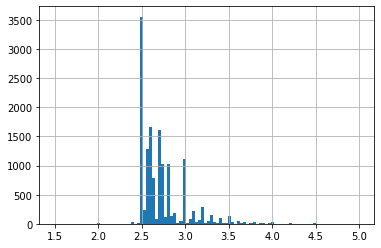

In [123]:
#Решим проблему потолков (для наглядности будем использовать метод hist, думаю это была пасхалка в этом проекте)
real_estate['ceiling_height'].hist(bins=100, range=(1.5, 5))
real_estate['ceiling_height'] = real_estate['ceiling_height'].fillna(real_estate['ceiling_height'].median())
#заменили на медианное значение т.к. график показывает, что в основном всё колеблется в пределах 2.5 - 3.0 м.

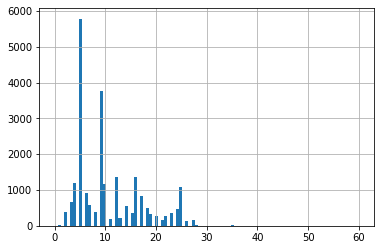

In [124]:
#Далее разберёмся с количеством этажей, опять же построим hist для наглядности
real_estate['floors_total'].hist(bins=100, range=(0, 60))
#пропусков очень мало, мы ничего не потеряем если уберём их
real_estate = real_estate.dropna(subset=['floors_total'])

In [125]:
#Значение столбцов parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, airports_nearest
#оставим такие как есть, т.к. они просто не заполнены и для дальнешей работы нам не потребуются.

In [126]:
#Теперь у нас кухня 
real_estate['kitchen_area'].isnull().sum()

2231

In [127]:
#Теперь у нас жилая площадь
real_estate['living_area'].isnull().sum()

1870

In [128]:
#Проверим, а не имеет ли это отношение к студиям где и стены то лишь несущие
real_estate.query('rooms == 0')[['kitchen_area', 'living_area']].isnull().sum()

kitchen_area    194
living_area      11
dtype: int64

In [129]:
#Неудачно, лишь малая часть пропусков относится к студиям. 
#Думаю можно заполнить пропуски медианой от отношение к общей площади.
#В слаке подсказали, это лучше чем оставлять с пропусками.
real_estate['kitchen_total'] = real_estate['kitchen_area'] / real_estate['total_area']
kitchen_total_median = real_estate['kitchen_total'].median()
real_estate['kitchen_area'] = real_estate['kitchen_area'].fillna(real_estate['total_area']*kitchen_total_median)
real_estate['living_total'] = real_estate['living_area'] / real_estate['total_area']
living_total_median = real_estate['living_total'].median()
real_estate['living_area'] = real_estate['living_area'].fillna(real_estate['total_area']*living_total_median)
real_estate['kitchen_area'].isnull().sum()
real_estate['living_area'].isnull().sum()

0

In [130]:
#Заполнение "cityCenters_nearest" не возможно средним или медианным значением. 
real_estate.isnull().sum().sort_values()/real_estate.shape[0]*100

total_images             0.000000
days_exposition          0.000000
balcony                  0.000000
kitchen_area             0.000000
studio                   0.000000
is_apartment             0.000000
floor                    0.000000
open_plan                0.000000
floors_total             0.000000
ceiling_height           0.000000
rooms                    0.000000
first_day_exposition     0.000000
total_area               0.000000
last_price               0.000000
living_area              0.000000
locality_name            0.203278
living_total             7.919366
kitchen_total            9.448185
parks_around3000        23.326134
ponds_around3000        23.326134
cityCenters_nearest     23.330369
airports_nearest        23.427773
ponds_nearest           61.627070
parks_nearest           65.929784
dtype: float64

In [131]:
#23% в пропусках по "центру", странно ведь это значение система сама выставляет, 
#видимо это были запросы совсем удалённых районов. Оставим без изменений.

In [132]:
#Посчитаем дубли
real_estate['locality_name'].duplicated().sum()
#есть дубли с буквами Е, Ё, т.е. кто как внёс, хотя считаю, 
#что Яндекс может жестко забить названия в раскрываемый список или автозамену делать
real_estate['locality_name'].unique().tolist()
#уберём их
real_estate['locality_name'] = real_estate['locality_name'].str.replace('ё', 'е', regex=True)
#проверим что получилось
real_estate['locality_name'].unique().tolist()

['Санкт-Петербург',
 'поселок Шушары',
 'городской поселок Янино-1',
 'поселок Парголово',
 'поселок Мурино',
 'Ломоносов',
 'Сертолово',
 'Петергоф',
 'Пушкин',
 'деревня Кудрово',
 'Коммунар',
 'Колпино',
 'поселок городского типа Красный Бор',
 'Гатчина',
 'деревня Федоровское',
 'Выборг',
 'Кронштадт',
 'Кировск',
 'деревня Новое Девяткино',
 'поселок Металлострой',
 'поселок городского типа Лебяжье',
 'поселок городского типа Сиверский',
 'поселок Молодцово',
 'поселок городского типа Кузьмоловский',
 'садовое товарищество Новая Ропша',
 'Павловск',
 'деревня Пикколово',
 'Всеволожск',
 'Волхов',
 'Кингисепп',
 'Приозерск',
 'Сестрорецк',
 'деревня Куттузи',
 'поселок Аннино',
 'поселок городского типа Ефимовский',
 'поселок Плодовое',
 'деревня Заклинье',
 'поселок Торковичи',
 'поселок Первомайское',
 'Красное Село',
 'поселок Понтонный',
 'Сясьстрой',
 'деревня Старая',
 'деревня Лесколово',
 'поселок Новый Свет',
 'Сланцы',
 'село Путилово',
 'Ивангород',
 'Мурино',
 'Шлиссель

In [133]:
#проверка наличия строк без города (пропусков), такие объявление не соответствуют требования Яндекс Недвижимость
real_estate['locality_name'].isna().sum()
#уберём их
real_estate = real_estate.dropna(subset=['locality_name'])
#итоговая проверка
real_estate['locality_name'].isna().sum()

0

In [134]:
#Поменяем дату первой публикации на удобную для итоговых расчётов
real_estate['first_day_exposition'] = pd.to_datetime(real_estate['first_day_exposition'], format="%Y-%m-%dT%H:%M:%S")
real_estate.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen_total,living_total
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.000000,8,0,...,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,95.0,0.231481,0.472222
1,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.600000,1,0,...,поселок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,0.272277,0.460396
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.300000,4,0,...,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,0.148214,0.612500
3,0,64900000.0,159.0,2015-07-24,3,2.65,14.0,90.340909,9,0,...,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,NaN,NaN
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.000000,13,0,...,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,0.410000,0.320000


In [ ]:
#Для 4-го блока сведения по cityCenters_nearest


### Шаг 3. Посчитайте и добавьте в таблицу

In [135]:
#Добавляем цену квадратного метра
real_estate['price_m2'] = real_estate['last_price'] / real_estate['total_area']
print(real_estate['price_m2'])

0        120370.370370
1         82920.792079
2         92785.714286
3        408176.100629
4        100000.000000
             ...      
23694     72490.845228
23695     52542.372881
23696     44091.710758
23697    149511.400651
23698     41795.665635
Name: price_m2, Length: 23565, dtype: float64


In [136]:
#Добавляем "день недели", "месяц" и "год публикации" объявления
real_estate['day'] = real_estate['first_day_exposition'].dt.weekday
real_estate['month'] = real_estate['first_day_exposition'].dt.month
real_estate['year'] = real_estate['first_day_exposition'].dt.year
real_estate['first_day_exposition'] = real_estate['first_day_exposition'].dt.date

In [137]:
#Добавляем этажи
def floor_add(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
 
real_estate['floor_add'] = real_estate.apply(floor_add, axis=1)
print(real_estate['floor_add'])

0        другой
1        первый
2        другой
3        другой
4        другой
          ...  
23694    другой
23695    другой
23696    первый
23697    другой
23698    первый
Name: floor_add, Length: 23565, dtype: object


In [138]:
#Добавляем соотношение жилой и общей площади, а также отношение площади кухни к общей
real_estate['living_area_part'] = real_estate['living_area'] / real_estate['total_area']
real_estate['kitchen_area_part'] = real_estate['kitchen_area'] / real_estate['total_area']

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

In [139]:
#Проводим исследовательский анализ данных, и выполняем инструкции (вот этот блок и занял почти всю неделю с перерывами)
#Изучите следующие параметры: площадь, цена, число комнат, высота потолков. Постройте гистограммы для каждого параметра

12.0
900.0


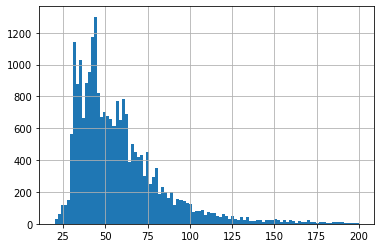

In [140]:
#Площадь
real_estate['total_area'].hist(bins=100, range=(20, 200))
print(real_estate['total_area'].min())
print(real_estate['total_area'].max())
#квартир в 20м2 и 200м2 совсем мало

12190.0
763000000.0


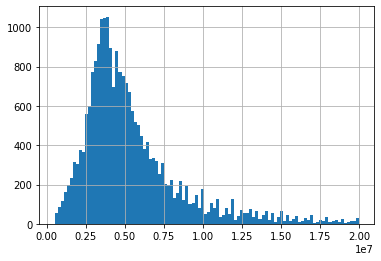

In [141]:
#Цена
real_estate['last_price'].hist(bins=100, range=(500000, 20000000))
print(real_estate['last_price'].min())
print(real_estate['last_price'].max())
#квартир с ценой меньше 500 тысяч рублей и больше 20 миллионов рублей меньше всего

[ 3  1  2  4  5  6  0  7 11  8 14 10 15  9 19 16 12]


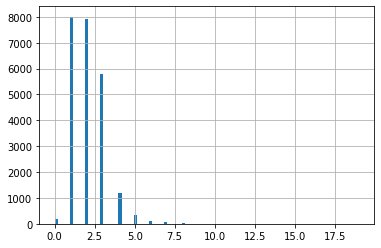

In [142]:
#Число комнат
real_estate['rooms'].hist(bins=100)
print(real_estate['rooms'].unique())
#8-ми комнатные квартиры их мало

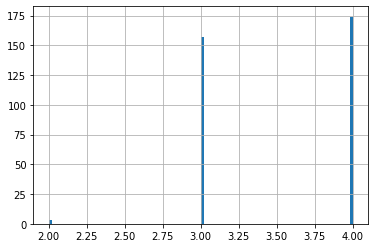

In [143]:
#Высота потолков
real_estate['days_exposition'].hist(bins=100, range=(2, 4))
#Потолков меньше 2 метров и больше 4 меньше всего

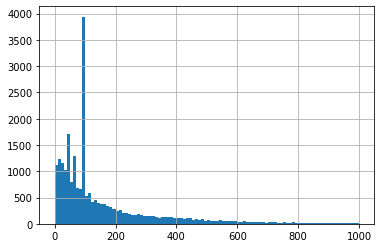

In [144]:
#Изучим время продажи квартиры
real_estate['days_exposition'].hist(bins=100, range=(0, 1000))

{'whiskers': [<matplotlib.lines.Line2D at 0x7f2dadb28890>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2dadc94bd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2dadb28190>],
 'medians': [<matplotlib.lines.Line2D at 0x7f2dadbf3410>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f2dadbf3350>],
 'means': []}

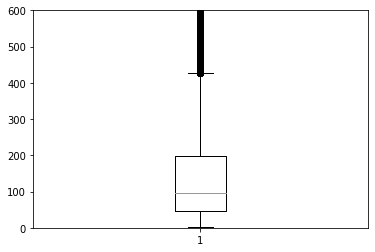

In [145]:
plt.ylim(0, 600)
plt.boxplot(real_estate['days_exposition'])
#Пороговое значение на уровне 100, т.е. 90 дней

                     price_m2     rooms  cityCenters_nearest
price_m2             1.000000  0.055680            -0.317596
rooms                0.055680  1.000000            -0.184096
cityCenters_nearest -0.317596 -0.184096             1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2dae554f90>,
      dtype=object)

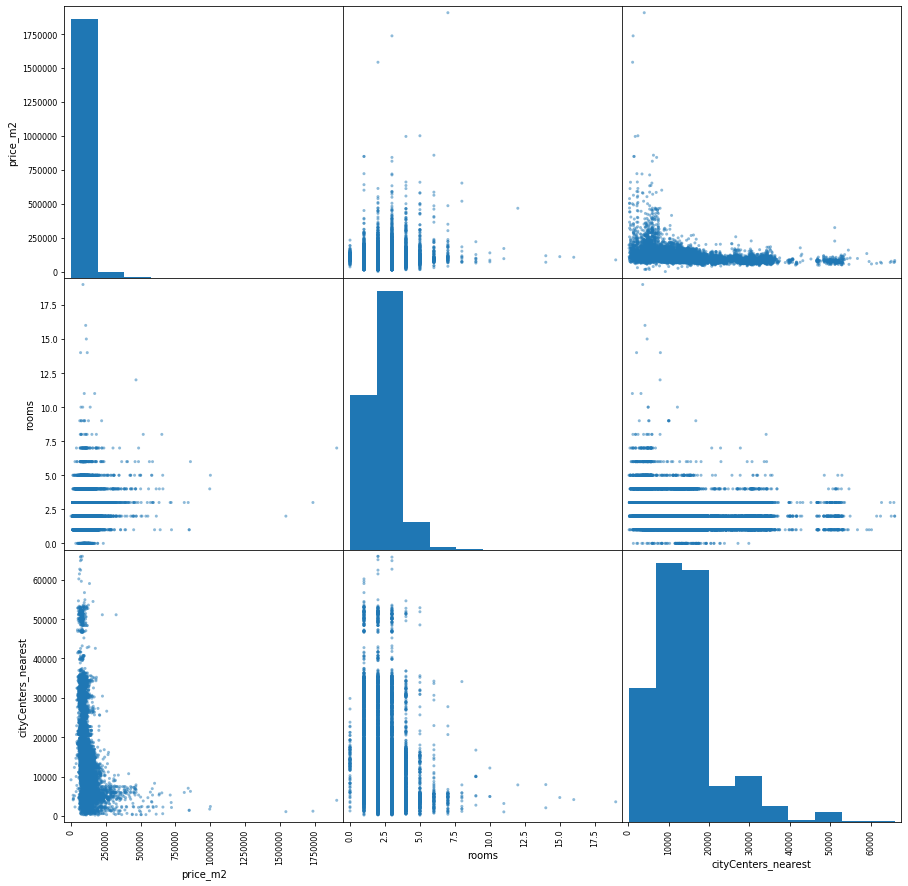

In [146]:
#Изучим зависимость цены от квадратного метра, числа комнат, удалённости от центра
estate_mrc = real_estate.loc[:, ['price_m2', 'rooms', 'cityCenters_nearest']]
print(estate_mrc.corr())
pd.plotting.scatter_matrix(estate_mrc, figsize=(15, 15))

In [147]:
#Цена снижается, если: далеко от центра, и много комнат, что логично, хотя в маленьких городах ситуация может быть иная.

               price_m2
floor_add              
другой     98288.070230
первый     81250.000000
последний  87763.152598


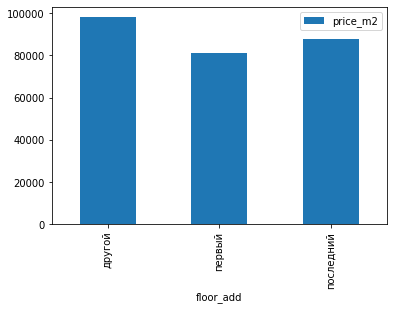

In [148]:
#Изучим зависимость цены от того, на каком этаже расположена квартира: первом, последнем или другом
real_estate_pivot_floors_category = real_estate.pivot_table(index='floor_add', values='price_m2', aggfunc='median')
real_estate_pivot_floors_category.plot(y='price_m2', kind ='bar')
print(real_estate_pivot_floors_category)

In [149]:
#Вывод также очевиден, чем ниже, тем дешевле, можно было бы жить в подвалах так вообще было очень дёшево))

         price_m2
day              
0    94719.931386
1    95567.638820
2    95473.807179
3    95132.918056
4    94579.892479
5    93548.387097
6    94594.594595


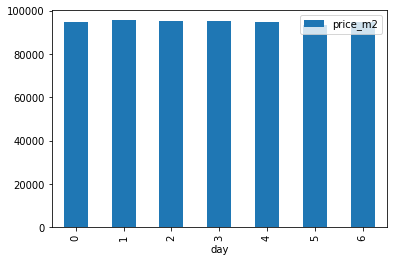

In [150]:
#Изучим зависимость от даты размещения: дня недели, месяца и года
real_estate_pivot_day = real_estate.pivot_table(index='day', values ='price_m2', aggfunc='median')
real_estate_pivot_day.plot(y='price_m2', kind ='bar')
print(real_estate_pivot_day)

           price_m2
month              
1      95180.722892
2      95000.000000
3      95233.265720
4      96543.700186
5      92696.629213
6      92857.142857
7      95005.938242
8      96052.631579
9      95623.540154
10     94212.560386
11     95606.617647
12     94238.400488


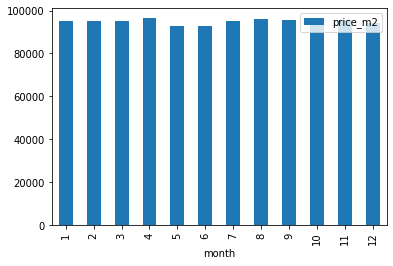

In [151]:
real_estate_pivot_month = real_estate.pivot_table(index='month', values ='price_m2', aggfunc='median')
real_estate_pivot_month.plot(y='price_m2', kind ='bar')
print(real_estate_pivot_month)

           price_m2
year               
2014  106901.898734
2015   93364.779874
2016   91743.119266
2017   92569.659443
2018   95696.352318
2019  103199.174407


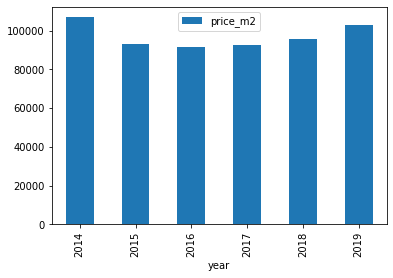

In [152]:
real_estate_pivot_year = real_estate.pivot_table(index='year', values ='price_m2', aggfunc='median')
real_estate_pivot_year.plot(y='price_m2', kind ='bar')
print(real_estate_pivot_year)

In [153]:
#Данные графики подтверждают логичные выводы, с понедельника по четверг цена в обьявлении выше, 
#в мае-июне метр дешевеет (мифический дачный сезон), 
#и в 2015 в связи в неблагоприятными геополитическими событиями и как следствие обесценивание нацвалюты, 
#драйверы роста просели (продажа квартир)

In [154]:
#Теперь посмотрим цену метра в 10 населённых пунктах Питера
real_estate_pivot_lnm = real_estate.pivot_table(index='locality_name', values ='price_m2', aggfunc='count')
real_estate_pivot_lnm = real_estate_pivot_lnm.sort_values(by = 'price_m2', ascending = False)
print(real_estate_pivot_lnm.head(10))

                   price_m2
locality_name              
Санкт-Петербург       15651
поселок Мурино          552
поселок Шушары          439
Всеволожск              398
Пушкин                  369
Колпино                 338
поселок Парголово       327
Гатчина                 307
деревня Кудрово         299
Выборг                  237


In [163]:
list_prigorod = ['Санкт-Петербург',
        'поселок Мурино', 
        'поселок Шушары', 
        'Всеволожск', 
        'пушкин', 
        'Колпино', 
        'поселок Парголово',
        'Гатчина',
        'деревня Кудрово',
        'Выборг']
real_estate_pr = real_estate.query('locality_name in @list_prigorod')
real_estate_pivot_lnm = real_estate_pr.pivot_table(index='locality_name', values =['price_m2', 'cityCenters_nearest'], aggfunc='median')
real_estate_pivot_lnm = real_estate_pivot_lnm.sort_values(by = 'price_m2', ascending = False)
print(real_estate_pivot_lnm)

                   cityCenters_nearest       price_m2
locality_name                                        
Санкт-Петербург                12242.0  104774.535809
деревня Кудрово                    NaN   91860.465116
поселок Парголово              19311.0   91642.857143
поселок Мурино                     NaN   86059.293995
поселок Шушары                 24212.0   76829.268293
Колпино                        32018.0   74723.748474
Гатчина                            NaN   67796.610169
Всеволожск                         NaN   65789.473684
Выборг                             NaN   58158.319871


In [ ]:
#В лидерах Санкт-петербург, потом посёлок Парголово, видимо что-то хорошее, и снова очевидное, чем ближе центр тем дороже

In [186]:
#Изучим предложения квартир по информации о расстоянии до центра

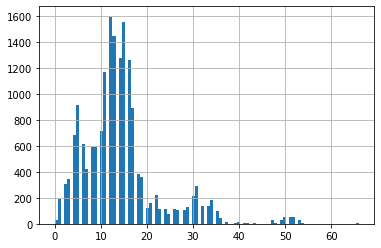

In [189]:
#Переводим в километры
real_estate['city_centers_nearest_km'] = real_estate['cityCenters_nearest'] / 1000
real_estate['city_centers_nearest_km'] = real_estate['city_centers_nearest_km'].round()
#real_estate['city_centers_nearest_km'].head()
real_estate['city_centers_nearest_km'].hist(bins=100)

real_estate_city_centers = real_estate
real_estate_city_centers_5 = real_estate_city_centers.query('city_centers_nearest_km < 5')
real_estate_city_centers_15 = real_estate_city_centers.query('5 <= city_centers_nearest_km < 15')
real_estate_city_centers_20 = real_estate_city_centers.query('15 <= city_centers_nearest_km < 20')
real_estate_city_centers_beyod = real_estate_city_centers.query('20 <= city_centers_nearest_km')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2dac38fb90>,
      dtype=object)

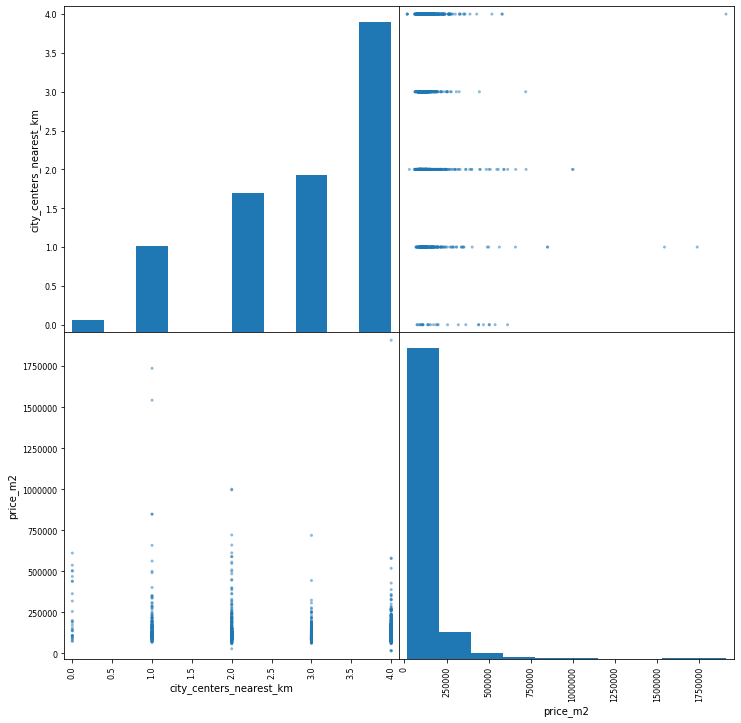

In [194]:
flat_5 = real_estate_city_centers_5.loc[:, ['city_centers_nearest_km', 'price_m2']]
pd.plotting.scatter_matrix(flat_5, figsize=(12, 12))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2dac444c90>,
      dtype=object)

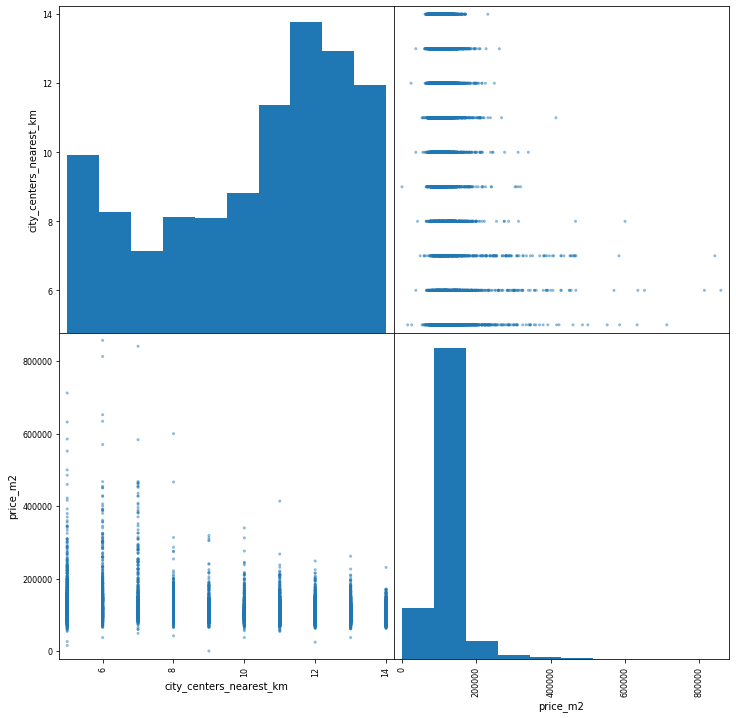

In [195]:
flat_15 = real_estate_city_centers_15.loc[:, ['city_centers_nearest_km', 'price_m2']]
pd.plotting.scatter_matrix(flat_15, figsize=(12, 12))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2da7dcc750>,
      dtype=object)

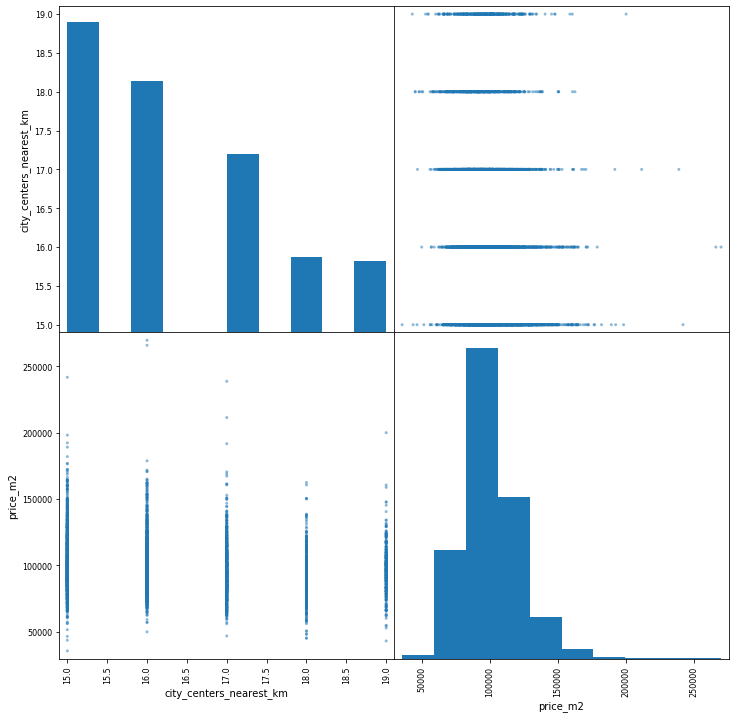

In [197]:
flat_20 = real_estate_city_centers_20.loc[:, ['city_centers_nearest_km', 'price_m2']]
pd.plotting.scatter_matrix(flat_20, figsize=(12, 12))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2dac39e950>,
      dtype=object)

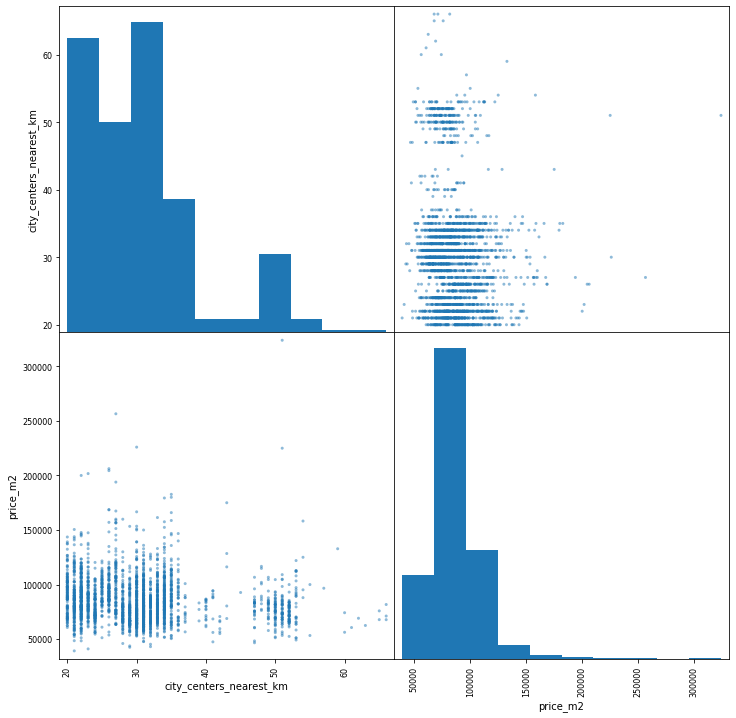

In [196]:
flat_beyod = real_estate_city_centers_beyod.loc[:, ['city_centers_nearest_km', 'price_m2']]
pd.plotting.scatter_matrix(flat_beyod, figsize=(12, 12))

In [ ]:
#Всё очевидно, хоть график и не идеальный но зависимость прямая, как и ранее

In [205]:
#Исследование сегмента квартир в центре
Flat_itog_1 = real_estate_city_centers_5.pivot_table(index='locality_name', 
                                    values=['rooms', 'total_area', 'last_price', 'ceiling_height'], 
                                    aggfunc='median')
print(Flat_itog_1)

                 ceiling_height  last_price  rooms  total_area
locality_name                                                 
Санкт-Петербург             3.0   9500000.0      3        83.0


In [204]:
Flat_itog_2 = real_estate_city_centers_15.pivot_table(index='locality_name', 
                                    values=['rooms', 'total_area', 'last_price', 'ceiling_height'], 
                                    aggfunc='median')
print(Flat_itog_2)

                 ceiling_height  last_price  rooms  total_area
locality_name                                                 
Санкт-Петербург            2.65   5650000.0      2        54.1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2da7149d90>,
      dtype=object)

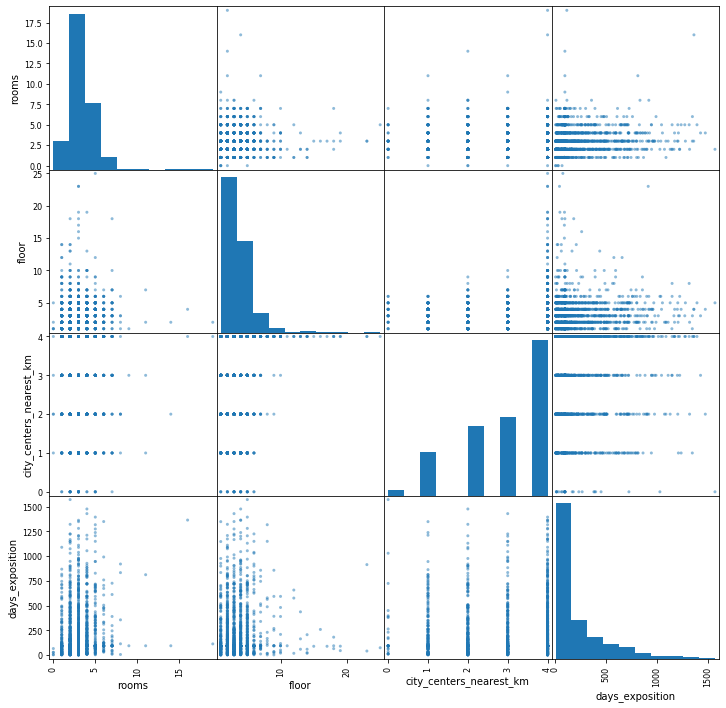

In [212]:
Flat_itog_3 = real_estate_city_centers_5.loc[:, ['rooms', 'floor', 'city_centers_nearest_km', 'days_exposition']]
pd.plotting.scatter_matrix(Flat_itog_3, figsize=(12, 12))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2da71443d0>,
      dtype=object)

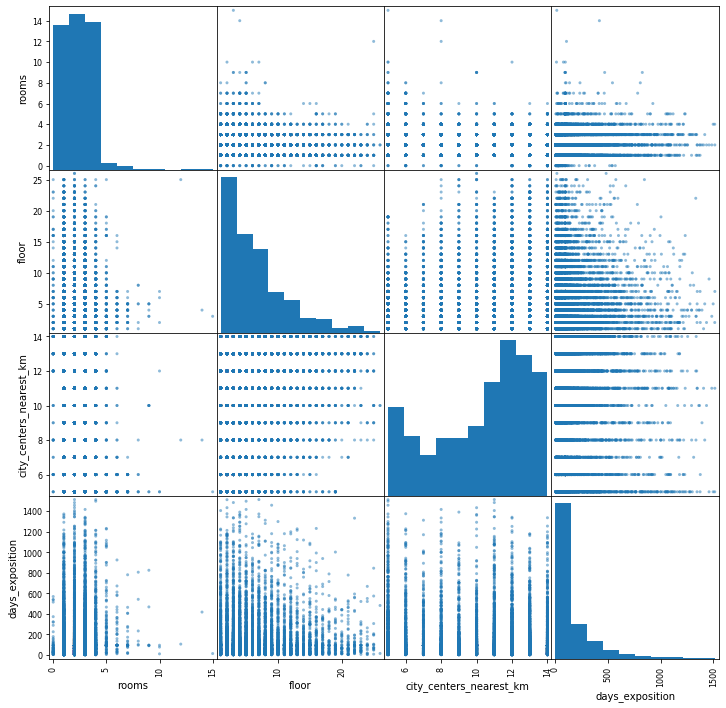

In [213]:
Flat_itog_4 = real_estate_city_centers_15.loc[:, ['rooms', 'floor', 'city_centers_nearest_km', 'days_exposition']]
pd.plotting.scatter_matrix(Flat_itog_4, figsize=(12, 12))

In [ ]:
#По графикам видна такая же зависимость цены от количества комнат, этажности, дней размещения, 
#отличий от ранее проведенного анализа городов нет 

### Шаг 5. Общий вывод

Проведенный анализ обьявлений выявил: недостатки в работе системы формирования обьявлений Яндекс. Недвижимость, а именно: очень много мусора, повторов, значений не в привычном для анализа формате (дата, расстояния). Рекомендуется оптимизация заполнения, а именно: контроль ввода значений, выбор из списка известных (типовых) точек опеределения расстояния (прирогод, центр города), модерация обьявлений в кот 
Проведенная работа позволила определить следующее:
- квартира продаётся в среднем за 90 дней;
- если квартира далеко от центра, и много комнат, то цена снижается квадратного метра;
- самый нижний этаж самый дешевый за квадрат;
- есть сезонное снижение цены;
- центр города наиболее релевантен по поиску обьявлений, хотя и ближайшие населенные пункты тоже пользуются спрсом;
- центр города может быть как за вменяемые деньги так и для миллионеров.

### Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод info())
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [х]  посчитано и добавлено в таблицу: цена квадратного метра
- [х]  посчитано и добавлено в таблицу: день недели, месяц и год публикации объявления
- [х]  посчитано и добавлено в таблицу: этаж квартиры; варианты — первый, последний, другой
- [х]  посчитано и добавлено в таблицу: соотношение жилой и общей площади, а также отношение площади кухни к общей
- [х]  изучены следующие параметры: площадь, цена, число комнат, высота потолков
- [х]  построены гистограммы для каждого параметра
- [х]  выполнено задание: "Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?"
- [х]  выполнено задание: "Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили."
- [х]  выполнено задание: "Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучите зависимость от даты размещения: дня недели, месяца и года. "Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце '*locality_name'*. "
- [х]  выполнено задание: "Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге (*'locality_name'*). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона. "
- [х]  выполнено задание: "Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?"
- [х]  в каждом этапе есть выводы
- [х]  есть общий вывод